# 꽃 이미지 분류하기
- 텐서플로우 학습 튜토리얼

##이 튜토리얼은 기본적인 머신러닝 워크플로를 따릅니다.
1.   데이터 검사 및 이해하기
2.   입력 파이프라인 빌드하기
3.   모델 빌드하기
4.   모델 훈련하기
5.   모델 테스트하기
6.   모델 개선하고 프로세스 반복하기





## TensorFlow 및 기타 라이브러리 가져오기

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

### 데이터 세트 다운로드 및 탐색하기
이 튜토리얼에서는 약 3,700장의 꽃 사진 데이터세트를 사용합니다.<br/>
데이터세트에서는 클래스당 하나씩 5개의 하위 디렉토리가 있습니다.

In [ ]:
import pathlib
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_url, untar=True)
data_dir = pathlib.Path(data_dir)

228818944/228813984 [==============================] - 3s 0us/step


다운로드 후, 데이터세트 사본을 사용할 수 있습니다. 총 3670개의 이미지가 있습니다.

In [ ]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3670


다음은 몇 가지 장미입니다.

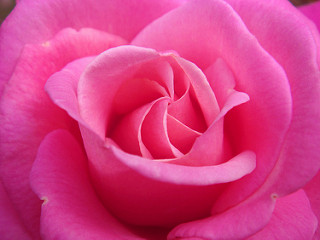

In [ ]:
roses = list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[0]))

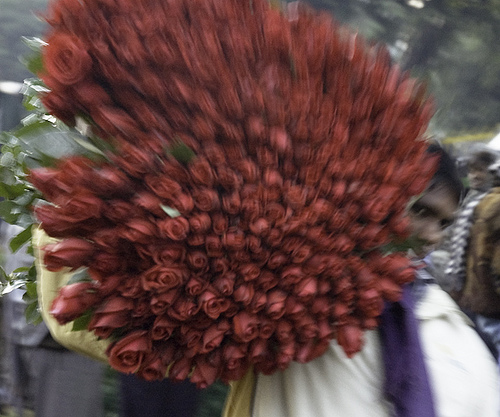

In [ ]:
PIL.Image.open(str(roses[1]))

튤립도 있습니다

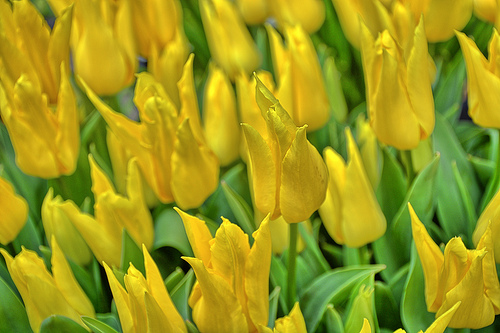

In [ ]:
tulips = list(data_dir.glob('tulips/*'))
PIL.Image.open(str(tulips[0]))

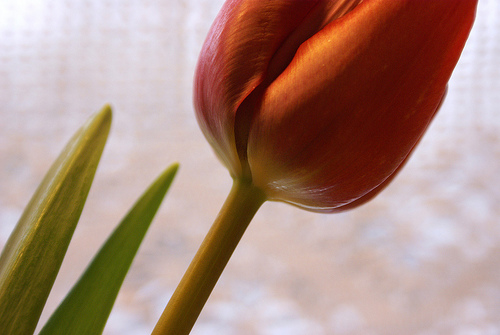

In [ ]:
PIL.Image.open(str(tulips[1]))

## keras.preprocessing을 사용하여 로드하기
유용한 image_dataset_from_directory 유틸리티를 사용하여 이러한 이미지를 디스크에 로드하겠습니다.<br/> 몇 줄의 코드만으로 디스크의 이미지 디렉토리가 tf.data.Dataset로 가져와 집니다.<br/> 원하는 경우, 이미지 로드 튜토리얼을 방문하여 데이터로드 코드를 처음부터 직접 작성할 수도 있습니디.

### 데이터세트 만들기
로더에 대한 몇 가지 매개변수를 정의합니다.

In [ ]:
batch_size = 32
img_height = 180
img_width = 180

모델을 개발할 때 검증 분할을 사용하는 것이 좋습니다. <br/>훈련에 이미지의 80%를 사용하고 검증에 20%를 사용합니다.

In [ ]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [ ]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


이러한 데이터세트의 class_names 속성에서 클래스 이름을 찾을 수 있습니다.<br/> 이들 클래스 이름은 알파벳 순서의 디렉토리 이름에 해당합니다.

In [ ]:
class_names = train_ds.class_names
print(class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


### 데이터 시각화하기
훈련 데이터세트의 처음 9개 이미지는 다음과 같습니다.

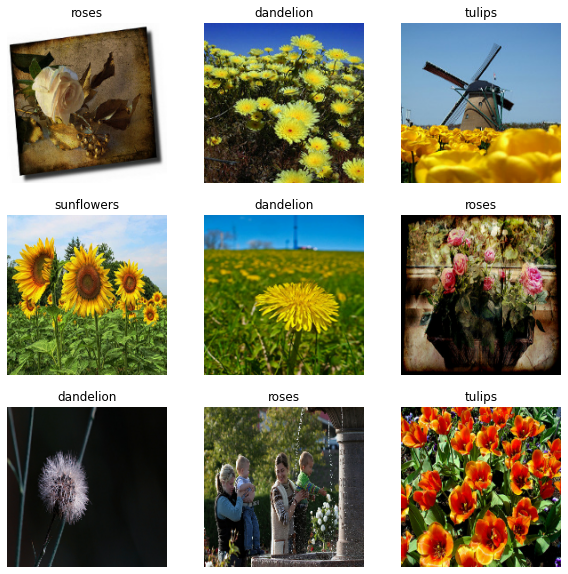

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

잠시 후에 이들 데이터세트를 model.fit에 전달하여 모델을 훈련하겠습니다.<br/> 원하는 경우, 이미지 배치를 검색할 수도 있습니다.

In [ ]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


image_batch는 (32, 180, 180, 3) 형상의 텐서이며, 180x180x3 형상의 32개 이미지 묶음으로 되어 있습니다.<br/>
(마지막 차원은 색상채널 RGB를 나타냄)
label_batch는 형상 (32,) 의 텐서이며 32개 이미지에 해당하는 레이블입니다.
<br/><br/>
image_batch 및 labels_batch 텐서에서 .numpy() 를 호출하여 이를 numpy.ndarray 로 변환할 수 있습니다.

### 성능을 높이도록 데이터세트 구성하기
버퍼링된 프리페치를 사용하여 I/O를 차단하지 않고 디스크에서 데이터를 생성할 수 있도록 하겠습니다.<br/>데이터를 로드할 때 다음 두 가지 중요한 메서드를 사용해야 합니다.
- Dataset.cache()는 첫 epoch 동안 디스크에서 이미지를 로드한 후 이미지를 메모리에 유지합니다.<br/>이렇게 하면 모델을 훈련하는 동안 데이터세트가 병목 상태가 되지 않습니다.</br>데이터세트가 너무 커서 메모리에 맞지 않는 경우,</br>
 이 메서드를 사용하여 성능이 높은 온디스크 캐시를 생성할 수도 있습니다.</br></br> 
- Dataset.prefetch()는 훈련 중에 데이터 전처리 및 모델 실행과 겹칩니다.
</br></br>
 데이터 성능 가이드에서 두 가지 방법과 디스크에 데이터를 캐싱하는 방법에 대해 자세히 알아볼 수 있습니다.


In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### 데이터 표준화하기
RGB 채널 값은 [0, 255] 범위에 있습니다. 신경망에는 이상적이지 않습니다.</br> 일반적으로 입력 값을 작게 만들어야 합니다. </br>  여기서는 Rescaling 레이어를 사용하여 값이 [0, 1]에 있도록 표준화합니다.

In [ ]:
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)

참고: 이 섹션에서 소개하는 Keras Preprocesing 유틸리티와 레이어는 현재 실험적 단계이며 변경될 수 있습니다.
<br/>
이 레이어를 사용하는 방법에는 두 가지가 있습니다. map을 호출하여 데이터세트에 레이어를 적용할 수 있습니다.

In [ ]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


또는 모델 정의 내에 레이어를 포함하여 배포를 단순화할 수 있습니다. 여기서는 두 번째 접근법을 사용할 것입니다.
</br></br>
참고: 이전에 image_dataset_from_directory의 image_size 인수를 사용하여 이미지 크기를 조정했습니다. 모델에 크기 조정 논리를 포함하려면 크기 조정 레이어를 사용할 수 있습니다.

## 모델 만들기
모델은 각각에 최대 풀 레이어가 있는 3개의 컨볼루션 블록으로 구성됩니다.</br> 그 위에 relu 활성화 함수에 의해 활성화되는 128개의 단위가 있는 완전히 연결된 레이어가 있습니다.</br> 이 모델은 높은 정확성을 고려해 조정되지 않았습니다. <br/>이 튜토리얼의 목표는 표준적인 접근법을 보여주는 것입니다

In [ ]:
num_classes = 5

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

### 모델 컴파일하기
이 튜토리얼에서는 optimizers.Adam 옵티마이저 및 losses.SparseCategoricalCrossentropy 손실 함수를 선택합니다.<br/> 각 훈련 epoch에 대한 훈련 및 검증 정확성을 보려면 metrics 인수를 전달합니다.

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

### 모델 요약
모델의 summary 메서드를 사용하여 네트워크의 모든 레이어를 봅니다.

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_3 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 45, 45, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 22, 22, 64)       

### 모델 훈련하기

In [ ]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
92/92 [==============================] - 3s 31ms/step - loss: 1.4166 - accuracy: 0.3893 - val_loss: 1.0964 - val_accuracy: 0.5572
Epoch 2/10
92/92 [==============================] - 2s 20ms/step - loss: 1.0204 - accuracy: 0.6018 - val_loss: 0.9713 - val_accuracy: 0.6267
Epoch 3/10
92/92 [==============================] - 2s 20ms/step - loss: 0.8045 - accuracy: 0.6962 - val_loss: 0.8654 - val_accuracy: 0.6676
Epoch 4/10
92/92 [==============================] - 2s 20ms/step - loss: 0.6077 - accuracy: 0.7790 - val_loss: 0.9662 - val_accuracy: 0.6458
Epoch 5/10
92/92 [==============================] - 2s 20ms/step - loss: 0.3875 - accuracy: 0.8634 - val_loss: 1.1008 - val_accuracy: 0.6294
Epoch 6/10
92/92 [==============================] - 2s 26ms/step - loss: 0.2453 - accuracy: 0.9227 - val_loss: 1.2423 - val_accuracy: 0.6431
Epoch 7/10
92/92 [==============================] - 2s 25ms/step - loss: 0.1521 - accuracy: 0.9547 - val_loss: 1.5363 - val_accuracy: 0.6294
Epoch 8/10
92

### 훈련 결과 시각화하기
훈련 및 검증 세트에 대한 손실과 정확성 플롯을 생성합니다.

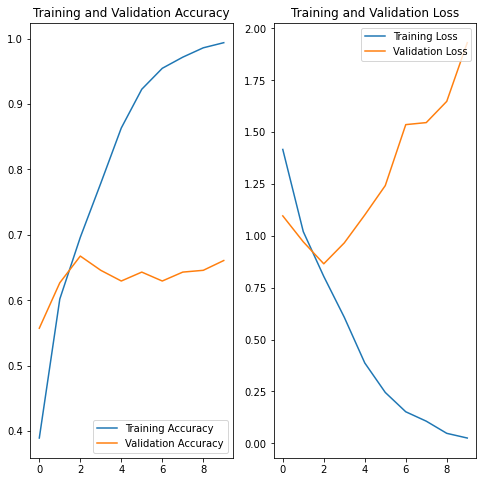

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

플롯에서 볼 수 있듯이 훈련 정확성과 검증 정확성은 큰 차이가 있으며, 모델은 검증 세트에서 약 60%의 정확성까지만 도달합니다.
</br>무엇이 잘못되었는지 살펴보고 모델의 전반적인 성능을 향상해 보겠습니다.


### 과대적합
위의 플롯에서 훈련 정확성은 시간이 지남에 따라 선형적으로 증가하는 반면, 검증 정확성은 훈련 과정에서 약 60%를 벗어나지 못합니다. 또한 훈련 정확성과 검증 정확성 간의 정확성 차이가 상당한데, 이는 과대적합의 징후입니다.
</br></br>
훈련 예제가 적을 때 모델은 새로운 예제에서 모델의 성능에 부정적인 영향을 미치는 정도까지 훈련 예제의 노이즈나 원치 않는 세부까지 학습합니다. 이 현상을 과대적합이라고 합니다. 이는 모델이 새 데이터세트에서 일반화하는 데 어려움이 있음을 의미합니다.
</br></br>
훈련 과정에서 과대적합을 막는 여러 가지 방법들이 있습니다. 이 튜토리얼에서는 데이터 증강을 사용하고 모델에 드롭아웃을 추가합니다.

### 데이터 증강
과대적합은 일반적으로 훈련 예제가 적을 때 발생합니다. 데이터 증강은 증강한 다음 믿을 수 있는 이미지를 생성하는 임의 변환을 사용하는 방법으로 기존 예제에서 추가 훈련 데이터를 생성하는 접근법을 취합니다. 그러면 모델이 데이터의 더 많은 측면을 파악하게 되므로 일반화가 더 쉬워집니다.
</br></br>
여기서는 실험적인 Keras 전처리 레이어를 사용하여 데이터 증강을 구현합니다. 이들 레이어는 다른 레이어와 마찬가지로 모델 내에 포함될 수 있으며, GPU에서 실행됩니다.

In [ ]:
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

동일한 이미지에 데이터 증강을 여러 번 적용하여 몇 가지 증강된 예제가 어떻게 보이는지 시각화하겠습니다.

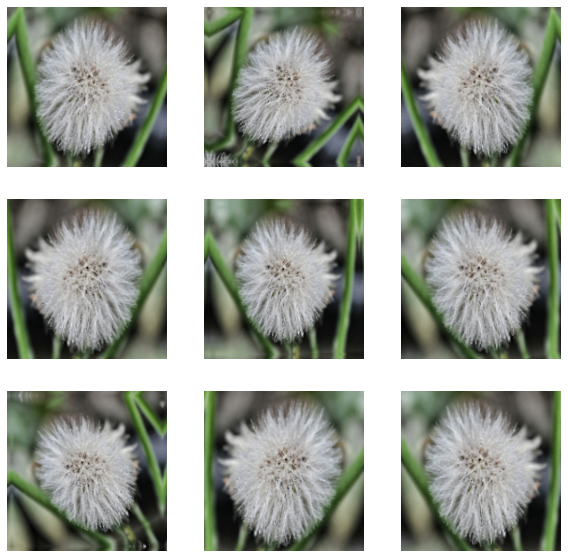

In [ ]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

### 드롭아웃
과대적합을 줄이는 또 다른 기술은 정규화의 한 형태인 드롭아웃을 네트워크에 도입하는 것입니다.
</br></br>
드롭아웃을 레이어에 적용하면, 훈련 프로세스 중에 레이어에서 여러 출력 단위가 무작위로 드롭아웃됩니다(활성화를 0으로 설정). 드롭아웃은 0.1, 0.2, 0.4 등의 형식으로 소수를 입력 값으로 사용합니다. 이는 적용된 레이어에서 출력 단위의 10%, 20% 또는 40%를 임의로 제거하는 것을 의미합니다.
</br></br>
layers.Dropout을 사용하여 새로운 신경망을 생성한 다음, 증강 이미지를 사용하여 훈련해 보겠습니다.

In [ ]:
model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

### 모델 컴파일 및 훈련하기

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_2 (Sequential)    (None, 180, 180, 3)       0         
_________________________________________________________________
rescaling_5 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 45, 45, 64)       

In [ ]:
epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15
92/92 [==============================] - 4s 27ms/step - loss: 1.4893 - accuracy: 0.4009 - val_loss: 1.1238 - val_accuracy: 0.5136
Epoch 2/15
92/92 [==============================] - 2s 25ms/step - loss: 1.1224 - accuracy: 0.5409 - val_loss: 1.0722 - val_accuracy: 0.5545
Epoch 3/15
92/92 [==============================] - 2s 22ms/step - loss: 1.0499 - accuracy: 0.5834 - val_loss: 1.0887 - val_accuracy: 0.5627
Epoch 4/15
92/92 [==============================] - 2s 22ms/step - loss: 1.0016 - accuracy: 0.5971 - val_loss: 0.9642 - val_accuracy: 0.6267
Epoch 5/15
92/92 [==============================] - 2s 22ms/step - loss: 0.9316 - accuracy: 0.6291 - val_loss: 0.9426 - val_accuracy: 0.6294
Epoch 6/15
92/92 [==============================] - 2s 22ms/step - loss: 0.8777 - accuracy: 0.6594 - val_loss: 0.8762 - val_accuracy: 0.6567
Epoch 7/15
92/92 [==============================] - 2s 22ms/step - loss: 0.8113 - accuracy: 0.6849 - val_loss: 0.8350 - val_accuracy: 0.6703
Epoch 8/15
92

### 훈련 결과 시각화하기
데이터 증강 및 드롭아웃을 적용한 후, 이전보다 과대적합이 줄어들고 훈련 및 검증 정확성이 더 가깝게 조정됩니다.

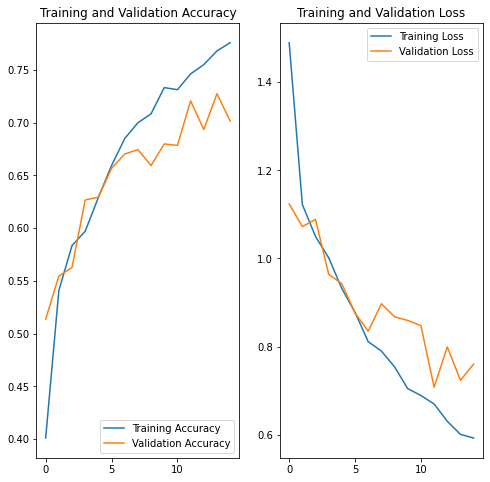

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


## 새로운 데이터로 예측하기
마지막으로, 모델을 사용하여 훈련 또는 검증 세트에 포함되지 않은 이미지를 분류해 보겠습니다.
</br></br>
참고: 데이터 증강 및 드롭아웃 레이어는 추론 시 비활성화됩니다.

In [ ]:
sunflower_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/592px-Red_sunflower.jpg"
sunflower_path = tf.keras.utils.get_file('Red_sunflower', origin=sunflower_url)

img = keras.preprocessing.image.load_img(
    sunflower_path, target_size=(img_height, img_width)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

122880/117948 [===============================] - 0s 0us/step
This image most likely belongs to sunflowers with a 97.85 percent confidence.
